In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


In [57]:
df = pd.read_csv('titanic_dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Lets first check for missing **values**

<Axes: >

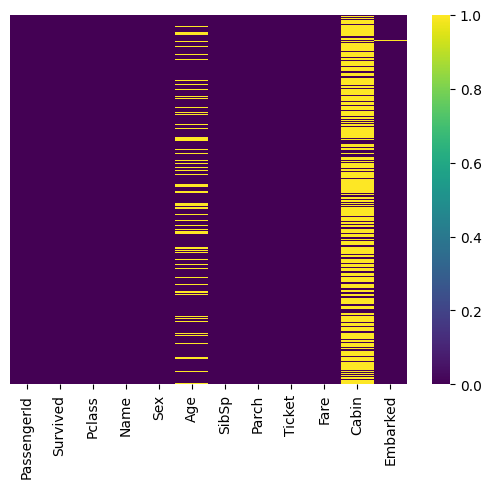

In [58]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')

What we observe is we have a lot of missing values in Age and Cabin column and 1 in Embarked column

In [59]:
df.drop(['Cabin','Ticket','PassengerId'],axis=1,inplace=True)

In [60]:
df = df.dropna(subset="Embarked",axis=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [61]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [62]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

# **Filling the missing values**


> We can take average w.r.t to any of the factors but we'll selelect PClass because its diveided into 3 categories so we'll get a more accurate answer




In [63]:
fig = px.box(x='Pclass',y='Age',data_frame = df)
fig.update_layout(width=700,height=400)
fig.show()

In [64]:

def English(str):
    st = str.split(", ")
    return st[1].split(". ")[0]

df['Title'] = df['Name'].apply(lambda x : English(x))
df.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [65]:
def impute_age(df):
  A = df['Age']
  Pclass = df['Pclass']

  if pd.isnull(A):

      if Pclass==1:
        return 37

      elif Pclass==2:
        return 29

      else:
        return 24
  else:
    return A

In [66]:
df['Age'] = df.apply(impute_age,axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


# **Visualizing the Data**

Cabin, Passenger ID and Ticket is not a very Important information for calculating he probability of suurvived or not survived so we can just drop that

Now we have to fill the missing values in age

<Axes: xlabel='Survived', ylabel='count'>

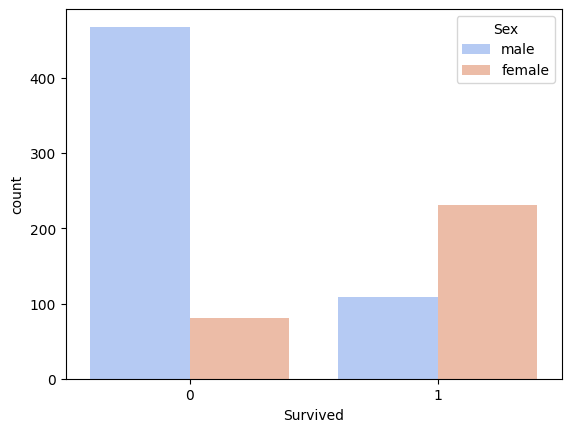

In [67]:
sns.countplot(x='Survived',hue='Sex',data=df,palette='coolwarm')

<Axes: xlabel='Survived', ylabel='count'>

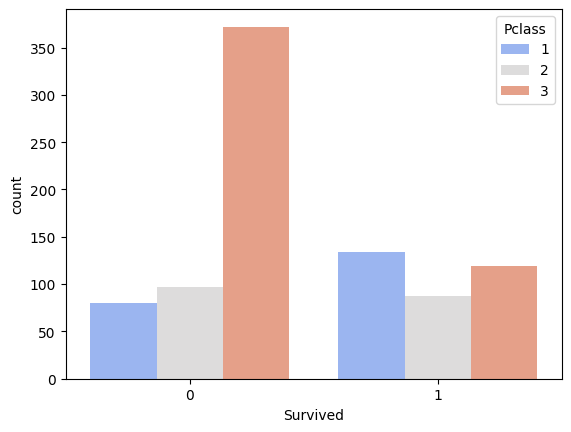

In [68]:
sns.countplot(x='Survived',hue='Pclass',data=df,palette='coolwarm')

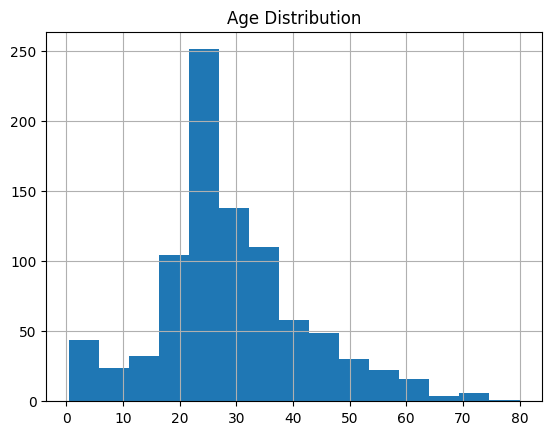

In [69]:
df['Age'].hist(bins=15)
plt.title('Age Distribution');

In [70]:
#sns.heatmap(df.corr(), annot=True)
#plt.title('Corelation Matrix');

<Axes: xlabel='Sex', ylabel='Age'>

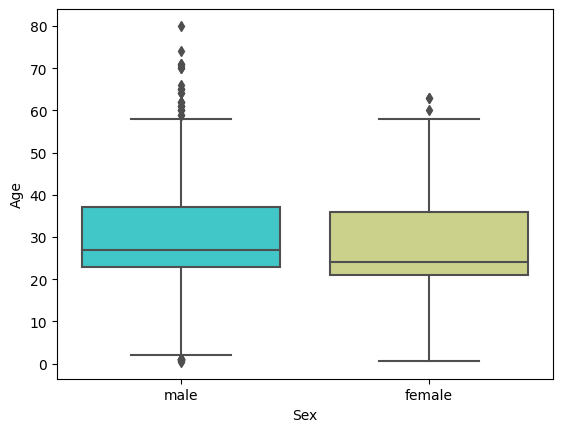

In [71]:
sns.boxplot(y='Age',x='Sex',data=df,palette='rainbow')


**No. of people who survived in the ship w.r.t their Fare**

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



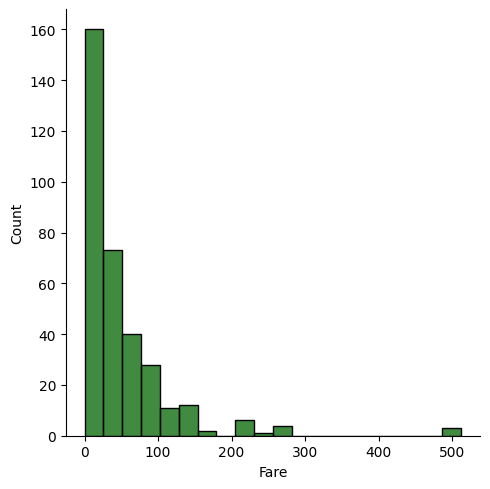

In [72]:
survived_fares = df[df['Survived'] == 1]['Fare'].dropna()
g = sns.displot(survived_fares, kde=False, color='darkgreen', bins=20)


Now group by

In [73]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


#**Question : How many men died on the ship who were in Pclass-3**

In [74]:
df[(df['Sex']=='male') & (df['Pclass'] == 3) & (df['Survived'] == 0)]['Name'].count()

300

In [75]:
df['Sex'].info()

<class 'pandas.core.series.Series'>
Index: 889 entries, 0 to 890
Series name: Sex
Non-Null Count  Dtype 
--------------  ----- 
889 non-null    object
dtypes: object(1)
memory usage: 13.9+ KB


#**Feature Engineering**

In [76]:
df2=df

We create a new Coloumn to stor the total size of people in one family

In [77]:
df2['familySize'] = df2['SibSp'] + df['Parch'] + 1

In [78]:
df2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,familySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,1


In [79]:
from sklearn.preprocessing import OneHotEncoder

encoded_columns = pd.get_dummies(df2['Embarked'], columns=['Embarked'])
df2 = pd.concat([df2, encoded_columns], axis=1)
df2.drop(columns='Embarked', inplace=True)


In [80]:
encoded_columns1 = pd.get_dummies(df2['Sex'], columns=['Sex'])
df2 = pd.concat([df2, encoded_columns1], axis=1)
df2.drop(columns='Sex', inplace=True)

In [81]:
# Lets drop the columns we don't need for our ML Model
df2 = df2.drop(['SibSp', 'Parch','Name','female','Title'], axis = 1)

In [82]:
df2.head()

,Survived,Pclass,Age,Fare,familySize,C,Q,S,male
0,0,3,22.0,7.2500,2,False,False,True,True
1,1,1,38.0,71.2833,2,True,False,False,False
2,1,3,26.0,7.9250,1,False,False,True,False
3,1,1,35.0,53.1000,2,False,False,True,False
4,0,3,35.0,8.0500,1,False,False,True,True


In [83]:
df2.dropna(subset=['S','Q','C'],axis=0)

,Survived,Pclass,Age,Fare,familySize,C,Q,S,male
0,0,3,22.0,7.2500,2,False,False,True,True
1,1,1,38.0,71.2833,2,True,False,False,False
2,1,3,26.0,7.9250,1,False,False,True,False
3,1,1,35.0,53.1000,2,False,False,True,False
4,0,3,35.0,8.0500,1,False,False,True,True
...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,1,False,False,True,True
887,1,1,19.0,30.0000,1,False,False,True,False
888,0,3,24.0,23.4500,4,False,False,True,False
889,1,1,26.0,30.0000,1,True,False,False,True


In [84]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
familySize    0
dtype: int64

In [85]:
from sklearn.model_selection import train_test_split
X = df2.drop(['Survived'],axis=1)
y = df2['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

# Scaling the Data

> Here we're using MinMax() Scaler because we don't need to preserve the units
We just want to keep the relation between two features as accurate as possible



In [86]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)

X_test_s = scaler.transform(X_test)

#Applying Machine Learning Models



## Logistic Regression



In [87]:

param_grid={
 'class_weight' : [None,'balanced'],
  'penalty': ['l1', 'l2', 'elasticnet', None],
  'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag'],
  'max_iter': [100,200,300]
}

In [88]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
cv=GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
cv.fit(X_train_s,y_train)

c:\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:498: LinAlgWarning:

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #4. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.00048e-17): result may not be accurate.

c:\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:498: LinAlgWarning:

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #2. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag']},
             scoring='accuracy')

In [89]:
y_pred=cv.predict(X_test_s)
logistic_score=accuracy_score(y_pred,y_test)
logistic_score

0.8027210884353742

In [90]:
cv.best_params_

{'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

## K Nearest neighbours

> First we'll find the best value for k through a line plot



In [91]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []

# Will take some time
for i in range(1,60):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_s,y_train)
    pred_i = knn.predict(X_test_s)
    error_rate.append(np.mean(pred_i != y_test))  # To avoid error rate becoming zero

In [92]:
fig = px.line(x=range(1, 60), y=error_rate,
              title='Error Rate vs. K Value',
              labels={'x': 'K', 'y': 'Error Rate'})
fig.update_traces(line=dict(color='blue', dash='dash'))
fig.update_layout(width=800, height=600)
fig.show()

In [93]:
knnclf = KNeighborsClassifier(n_neighbors=10)

# Train the model using the training sets
knnclf.fit(X_train_s, y_train)
y_pred = knnclf.predict(X_test_s)

knn_score=accuracy_score(y_pred,y_test)
knn_score

0.8197278911564626



 ## Decision Trees and Random Forests





In [94]:
param_grid={
 'criterion':['gini','entropy','log_loss'],
  'splitter':['best','random'],
  'max_depth':[1,2,3,4,5],
  'max_features':['sqrt', 'log2']
}

In [95]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
cv=GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
cv.fit(X_train,y_train)
y_pred=cv.predict(X_test)

In [96]:
Decsion_Tree_score=accuracy_score(y_pred,y_test)
Decsion_Tree_score

0.8163265306122449

In [97]:
# Parameters that were used
cv.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'log2',
 'splitter': 'best'}

In [98]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)    # We did not take 350 beacause it will overfit our Model
cv=GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
cv.fit(X_train,y_train)
y_pred=cv.predict(X_test)

rf_score=accuracy_score(y_pred,y_test)
rf_score

0.8027210884353742





 ## Checking how much each feature is affecting the Model





In [99]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

# Fit the model
model.fit(X, y)

feature_importances = model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

Pclass: 0.10171090520060702
Age: 0.25484817820746786
Fare: 0.24366553570296104
familySize: 0.06666878377427357
C: 0.010295682412245608
Q: 0.005386983771691774
S: 0.01579559706684477
male: 0.30162833386390847




## Support Vector Machine



In [100]:
param_grid = {'C': [0.1,1, 10, 100, 1000],
              'gamma': ['scale', 'auto'] ,
              'kernel': ['rbf','sigmoid','poly','linear']}

In [101]:
from sklearn.svm import SVC

model = SVC()
cv = GridSearchCV(model,param_grid,cv=5,scoring='accuracy')
model.fit(X_train_s,y_train)

SVC()

In [102]:
y_pred = model.predict(X_test_s)
svm_score = accuracy_score(y_pred,y_test)
svm_score

0.826530612244898

### Comparing the Accuracies of every Model

In [104]:
print("Accuracy with Logistic Regression : ",logistic_score)
print("\n")
print("Accuracy with K Nearest Neighbours Classification: ",knn_score)
print("\n")
print("Accuracy with Decision Trees : ",Decsion_Tree_score)
print("\n")
print("Accuracy with Random Forests  : ",rf_score)
print("\n")
print("Accuracy with Support Vector Machines : ",svm_score)


Accuracy with Logistic Regression :  0.8027210884353742


Accuracy with K Nearest Neighbours Classification:  0.8197278911564626


Accuracy with Decision Trees :  0.8163265306122449


Accuracy with Random Forests  :  0.8027210884353742


Accuracy with Support Vector Machines :  0.826530612244898
